# `Data Preprocessing`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob

dir = []
#reading the directon of images
for name in sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/DL_2/camvid_2/images/*.png')):
    dir.append(name.split('/')[-1])
dir[0]

'0001TP_006690.png'

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

#reading images and store them
data = []
size = (256,256)
for i in range(len(dir)):

    img = cv2.imread("/content/drive/My Drive/Colab Notebooks/DL_2/camvid_2/images/"+dir[i])
    img_bgr = cv2.resize(img, size)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    if img is not None:
      data.append(img_rgb)

# Mask

In [ ]:
import glob

dir_mask= []
#mask direction
for name in sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/DL_2/LabeledApproved_full.zip (Unzipped Files)/*.png')):
    dir_mask.append(name.split('/')[-1])
dir_mask

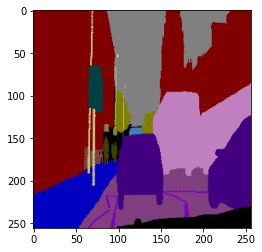

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#reading one  mask 
a = cv2.imread("/content/drive/My Drive/Colab Notebooks/DL_2/LabeledApproved_full.zip (Unzipped Files)/"+dir_mask[0])
img_bgr = cv2.resize(a, (256,256))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#reading masks and store them

mask = []
size = (256,256)
for i in range(len(dir_mask)):

    img = cv2.imread("/content/drive/My Drive/Colab Notebooks/DL_2/LabeledApproved_full.zip (Unzipped Files)/"+dir_mask[i])
    img_bgr = cv2.resize(img, size)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    if img is not None:
      mask.append(img_rgb)

In [ ]:
len(mask)

701

In [ ]:
from sklearn.model_selection import train_test_split    #spliting data to test and train
X_main, X_test, y_main, y_test = train_test_split(data, mask , test_size=0.05, random_state=None)

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X_main, y_main , test_size=0.10, random_state=None)

In [ ]:
#data normalization
import torchvision
X_train_normal = []
X_test_normal = []
X_validation_normal = []

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        #mean=[0.485, 0.456, 0.406],
        #std=[0.229, 0.224, 0.225],
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5],
    ),
])
for i in range(len(X_train)):
    X_train_normal.append(transform(X_train[i])) 

for i in range(len(X_test)):
    X_test_normal.append(transform(X_test[i])) 

for i in range(len(X_validation)):
    X_validation_normal.append(transform(X_validation[i])) 

In [ ]:
import pandas as pd
#reading the color of the classes
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DL_2/classes.csv')
s = pd.Series(["Animal","Archway","Bicyclist","Bridge","Building","Car","CartLuggagePram","Child","Column_Pole","Fence","LaneMkgsDriv","LaneMkgsNonDriv","Misc_Text","MotorcycleScooter","OtherMoving","ParkingBlock","Pedestrian","Road","RoadShoulder","Sidewalk","SignSymbol","Sky","SUVPickupTruck","TrafficCone","TrafficLight","Train","Tree","Truck_Bus","Tunnel","VegetationMisc","Void","Wall"])
df = df.set_index([s])
color_class = dict([(i,[r,g,b ]) for i, r,g,b in zip(df.index, df.R,df.G,df.B)])


In [ ]:
classes = []
b = color_class .values()
for i in b:
    classes.append(i)


In [ ]:
def adjust_mask(mask, flat=False):  #code from internet :https://www.kaggle.com/drnykterstein/camvid-semantic-segmentation
    
    semantic_map = []
    for colour in list(color_class.values()):        
        equality = np.equal(mask, colour)# cheching equality with True or False
        class_map = np.all(equality, axis = -1)# check if all is True
        semantic_map.append(class_map)# list of True or False
        
    semantic_map = np.stack(semantic_map, axis=-1)

    if flat:
      semantic_map = np.reshape(semantic_map, (-1,256*256))

    return np.argmax(np.float32(semantic_map),axis=-1)# convert to numbers and returns maximum
    #return np.float32(semantic_map)# convert to numbers

In [ ]:
labels_train = adjust_mask(y_train)
labels_test = adjust_mask(y_test)
labels_validation = adjust_mask(y_validation)

In [ ]:
X_train_normal[0].shape

torch.Size([3, 256, 256])

In [ ]:
labels_train[0].shape

(256, 256)

In [ ]:
X_test_normal[0].shape

torch.Size([3, 256, 256])

In [ ]:
testset = list(zip(X_test_normal , labels_test))
validationset = list(zip(X_validation_normal , labels_validation))
trainset = list(zip(X_train_normal , labels_train))

In [ ]:
import torch
#create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)                                        

validationloader = torch.utils.data.DataLoader(validationset, batch_size=4,
                                         shuffle=False, num_workers=2)



# Network without Batch Normalization layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegNet(nn.Module):
    def __init__(self):
            super(SegNet , self).__init__()
  
            self.conv1 = nn.Conv2d(3, 64, 7,1,3)
            self.conv2 = nn.Conv2d(64, 64, 7,1,3)
            self.softmax = nn.Conv2d(64,32,1,1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2 , return_indices=True )
            self.unpool = nn.MaxUnpool2d(2, stride=2)


    def forward(self, x):

      #encoder

      indices = []
      #print(x.shape)
      x , ind = self.pool(F.relu(self.conv1(x)))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.conv2(x)))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.conv2(x)))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.conv2(x)))
      indices.append(ind)
      #print(x.shape)

      #deocder
      
      x = self.unpool(x , indices[-1])
      x = F.relu(self.conv2(x))
      #print(x.shape)

      x = self.unpool(x , indices[-2])
      x = F.relu(self.conv2(x))
      #print(x.shape)

      x = self.unpool(x , indices[-3])
      x = F.relu(self.conv2(x))
      #print(x.shape)

      x = self.unpool(x , indices[-4])
      x = F.relu(self.conv2(x))
      #print(x.shape)

      #last layer
      pred = self.softmax(x)
      #print(pred.shape)
      return pred

net = SegNet()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9 , weight_decay=0.0005)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
net.to(device)

SegNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (softmax): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
)

In [ ]:
loss_data = []
loss_data_validation = []
for epoch in range(60):  # loop over the dataset multiple times

    #train
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        
        outputs = net(inputs.float())
        outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
        outputs = torch.transpose(outputs,1,2).contiguous()
        outputs = outputs.view(-1,outputs.size(2))

        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    #print('epoch %d -> loss: %.3f' %(epoch + 1, running_loss/i ))

    #validation
    running_loss_val = 0.0
    for j, data_val in enumerate(validationloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)

        
        outputs_val = net(inputs_val.float())
        outputs_val = outputs_val.view(outputs_val.size(0),outputs_val.size(1), -1)
        outputs_val = torch.transpose(outputs_val,1,2).contiguous()
        outputs_val = outputs_val.view(-1,outputs_val.size(2))

        loss_val = criterion(outputs_val, labels_val.reshape(-1))
        running_loss_val += loss_val.item()
    print('epoch %d : loss: %.3f   ,  validation loss: %.3f' %(epoch + 1, running_loss/i  ,  running_loss_val/j ))

    loss_data.append(running_loss/i)
    loss_data_validation.append(running_loss_val/j)

print('Finished Training')

epoch 1 : loss: 3.358   ,  validation loss: 3.434
epoch 2 : loss: 3.146   ,  validation loss: 3.189
epoch 3 : loss: 2.508   ,  validation loss: 2.323
epoch 4 : loss: 2.057   ,  validation loss: 2.071
epoch 5 : loss: 1.916   ,  validation loss: 1.942
epoch 6 : loss: 1.792   ,  validation loss: 1.866
epoch 7 : loss: 1.666   ,  validation loss: 2.080
epoch 8 : loss: 1.571   ,  validation loss: 1.673
epoch 9 : loss: 1.456   ,  validation loss: 1.533
epoch 10 : loss: 1.395   ,  validation loss: 1.419
epoch 11 : loss: 1.337   ,  validation loss: 1.609
epoch 12 : loss: 1.336   ,  validation loss: 1.482
epoch 13 : loss: 1.279   ,  validation loss: 1.331
epoch 14 : loss: 1.234   ,  validation loss: 1.437
epoch 15 : loss: 1.235   ,  validation loss: 1.313
epoch 16 : loss: 1.200   ,  validation loss: 1.324
epoch 17 : loss: 1.182   ,  validation loss: 1.200
epoch 18 : loss: 1.161   ,  validation loss: 1.230
epoch 19 : loss: 1.121   ,  validation loss: 1.188
epoch 20 : loss: 1.119   ,  validation l

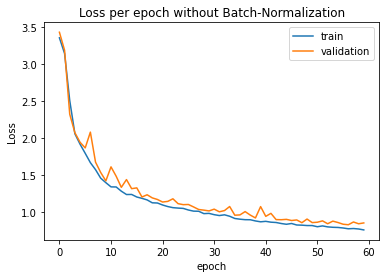

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_data )
plt.plot(loss_data_validation)
plt.title('Loss per epoch without Batch-Normalization')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


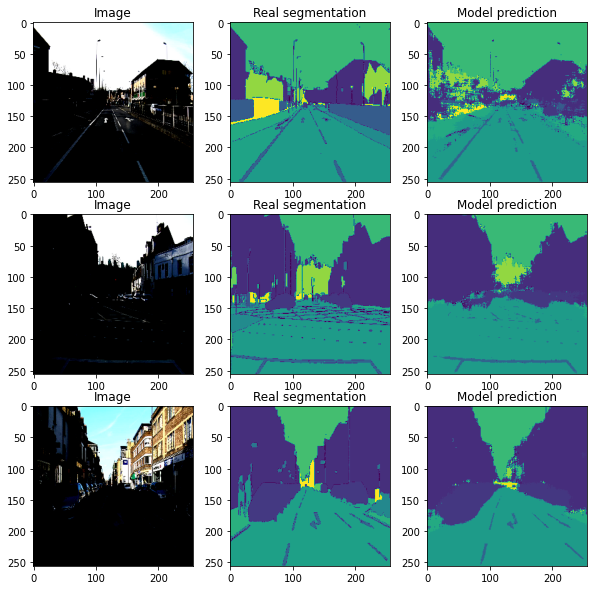

In [ ]:
import random
fig, axs = plt.subplots(3,3,figsize=(10,10))
count = 0

rand = []
for l in range(0,3):
    rand.append(random.randint(0,35))

for k, data_test in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)

        for h in range(0,3):
            if k == rand[h]:

                  axs[h][0].set_title('Image')
                  axs[h][1].set_title('Real segmentation')
                  axs[h][2].set_title('Model prediction')

                  outputs = net(inputs_test.float())
                  y_pred = torch.argmax(outputs, dim=1)
                  axs[h][2].imshow(y_pred[0].cpu())
                  axs[h][1].imshow(labels_test[0].cpu())
                  axs[h][0].imshow(inputs_test[0].permute(1,2,0).cpu())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


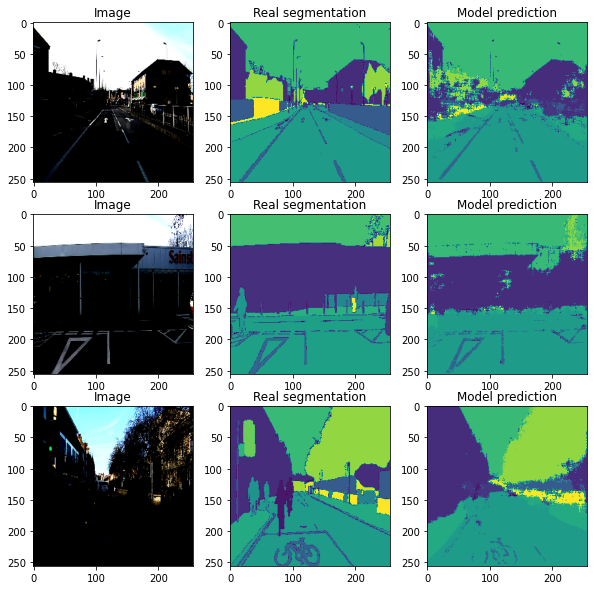

In [ ]:
import random
fig, axs = plt.subplots(3,3,figsize=(10,10))
count = 0

rand = []
for l in range(0,3):
    rand.append(random.randint(0,35))

for k, data_test in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)

        for h in range(0,3):
            if k == rand[h]:

                  axs[h][0].set_title('Image')
                  axs[h][1].set_title('Real segmentation')
                  axs[h][2].set_title('Model prediction')

                  outputs = net(inputs_test.float())
                  y_pred = torch.argmax(outputs, dim=1)
                  axs[h][2].imshow(y_pred[0].cpu())
                  axs[h][1].imshow(labels_test[0].cpu())
                  axs[h][0].imshow(inputs_test[0].permute(1,2,0).cpu())


In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/DL2_Q1_vfinal.pth'
torch.save(net.state_dict(), PATH)

# Network with batch Normalization layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegNet_BN(nn.Module):
    def __init__(self):
            super(SegNet_BN , self).__init__()
  
            self.conv1 = nn.Conv2d(3, 64, 7,1,3)
            self.conv2 = nn.Conv2d(64, 64, 7,1,3)
            self.softmax = nn.Conv2d(64,32,1,1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2 , return_indices=True )
            self.unpool = nn.MaxUnpool2d(2, stride=2)
            self.bn = nn.BatchNorm2d(64)


    def forward(self, x):

      #encoder

      indices = []
      #print(x.shape)
      x , ind = self.pool(F.relu(self.bn(self.conv1(x))))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.bn(self.conv2(x))))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.bn(self.conv2(x))))
      indices.append(ind)
      #print(x.shape)

      x , ind = self.pool(F.relu(self.bn(self.conv2(x))))
      indices.append(ind)
      #print(x.shape)

      #deocder
      
      x = self.unpool(x , indices[-1])
      x = F.relu(self.bn(self.conv2(x)))
      #print(x.shape)

      x = self.unpool(x , indices[-2])
      x = F.relu(self.bn(self.conv2(x)))
      #print(x.shape)

      x = self.unpool(x , indices[-3])
      x = F.relu(self.bn(self.conv2(x)))
      #print(x.shape)

      x = self.unpool(x , indices[-4])
      x = F.relu(self.bn(self.conv2(x)))
      #print(x.shape)

      #last layer
      pred = self.softmax(x)
      #print(pred.shape)
      return pred

net_bn = SegNet_BN()
net_bn.to(device)

SegNet_BN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (softmax): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_bn.parameters(), lr=0.001, momentum=0.9 , weight_decay=0.0005)

In [ ]:
loss_data_bn = []
loss_data_validation_bn = []
for epoch in range(60):  # loop over the dataset multiple times

    #train
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        
        outputs = net_bn(inputs.float())
        outputs = outputs.view(outputs.size(0),outputs.size(1), -1)
        outputs = torch.transpose(outputs,1,2).contiguous()
        outputs = outputs.view(-1,outputs.size(2))

        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    #print('epoch %d -> loss: %.3f' %(epoch + 1, running_loss/i ))

    #validation
    running_loss_val = 0.0
    for j, data_val in enumerate(validationloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)

        
        outputs_val = net_bn(inputs_val.float())
        outputs_val = outputs_val.view(outputs_val.size(0),outputs_val.size(1), -1)
        outputs_val = torch.transpose(outputs_val,1,2).contiguous()
        outputs_val = outputs_val.view(-1,outputs_val.size(2))

        loss_val = criterion(outputs_val, labels_val.reshape(-1))
        running_loss_val += loss_val.item()
    print('epoch %d : loss: %.3f   ,  validation loss: %.3f' %(epoch + 1, running_loss/i  ,  running_loss_val/j ))

    loss_data_bn.append(running_loss/i)
    loss_data_validation_bn.append(running_loss_val/j)

print('Finished Training')

epoch 1 : loss: 2.423   ,  validation loss: 1.720
epoch 2 : loss: 1.518   ,  validation loss: 1.531
epoch 3 : loss: 1.378   ,  validation loss: 1.370
epoch 4 : loss: 1.252   ,  validation loss: 1.265
epoch 5 : loss: 1.162   ,  validation loss: 1.196
epoch 6 : loss: 1.108   ,  validation loss: 1.150
epoch 7 : loss: 1.063   ,  validation loss: 1.114
epoch 8 : loss: 1.039   ,  validation loss: 1.079
epoch 9 : loss: 0.998   ,  validation loss: 1.087
epoch 10 : loss: 0.976   ,  validation loss: 1.047
epoch 11 : loss: 0.941   ,  validation loss: 1.026
epoch 12 : loss: 0.926   ,  validation loss: 0.980
epoch 13 : loss: 0.898   ,  validation loss: 0.953
epoch 14 : loss: 0.887   ,  validation loss: 0.961
epoch 15 : loss: 0.873   ,  validation loss: 0.931
epoch 16 : loss: 0.862   ,  validation loss: 0.919
epoch 17 : loss: 0.856   ,  validation loss: 0.906
epoch 18 : loss: 0.830   ,  validation loss: 0.893
epoch 19 : loss: 0.823   ,  validation loss: 0.888
epoch 20 : loss: 0.807   ,  validation l

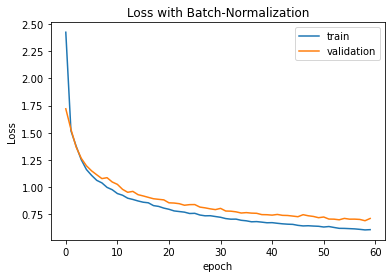

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_data_bn )
plt.plot(loss_data_validation_bn)
plt.title('Loss with Batch-Normalization')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','validation']);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


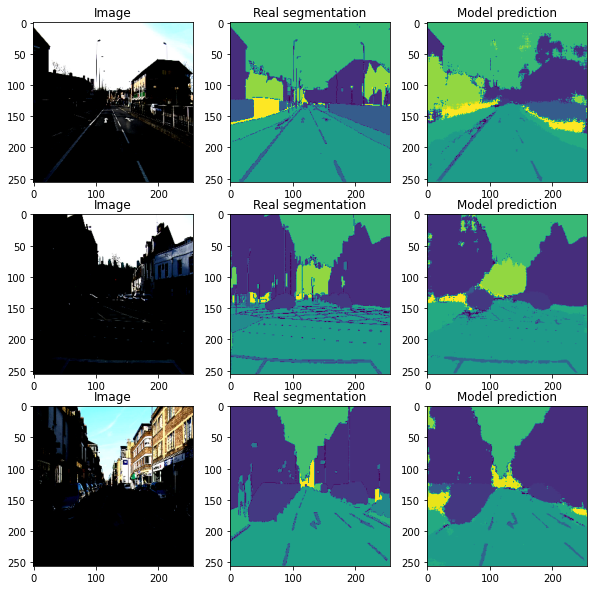

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
count = 0
for k, data_test in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)
        for h in range(0,3):
            if k == rand[h]:
              axs[h][0].set_title('Image')
              axs[h][1].set_title('Real segmentation')
              axs[h][2].set_title('Model prediction')

              outputs = net_bn(inputs_test.float())
              y_pred = torch.argmax(outputs, dim=1)
              axs[h][2].imshow(y_pred[0].cpu())
              axs[h][1].imshow(labels_test[0].cpu())
              axs[h][0].imshow(inputs_test[0].permute(1,2,0).cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


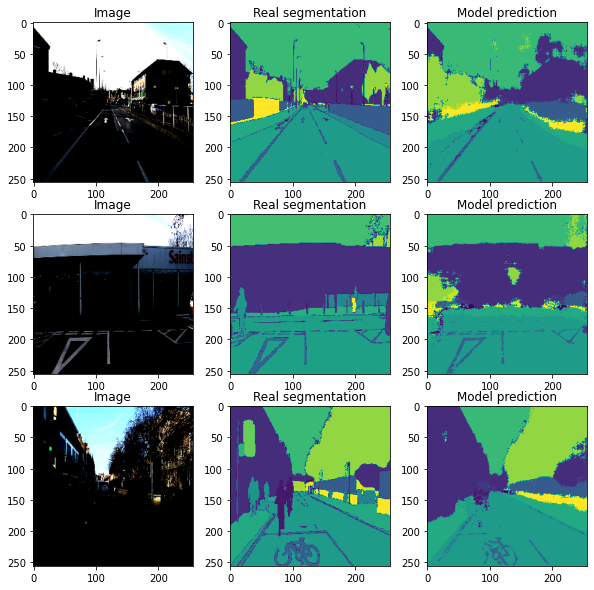

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(10,10))
count = 0
for k, data_test in enumerate(testloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs_test, labels_test = data_test[0].to(device), data_test[1].to(device)
        for h in range(0,3):
            if k == rand[h]:
              axs[h][0].set_title('Image')
              axs[h][1].set_title('Real segmentation')
              axs[h][2].set_title('Model prediction')

              outputs = net_bn(inputs_test.float())
              y_pred = torch.argmax(outputs, dim=1)
              axs[h][2].imshow(y_pred[0].cpu())
              axs[h][1].imshow(labels_test[0].cpu())
              axs[h][0].imshow(inputs_test[0].permute(1,2,0).cpu())

In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/DL_2_bn_v2.pth'
torch.save(net.state_dict(), PATH)